In [1]:
# load in the correct modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD THE DATA
path = '/Users/dhortadarrington/Documents/Master/data/allstar-dr17-StarHorse-Gaiadr3'
tb = fits.open(path)
data = tb[1].data 

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'GC_catalogo_14_mayo.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb2 = fits.open(path+file)
data2 = tb2[1].data
gc_star_ids = data2.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids))+' GC stars')

# LOAD THE DATA FOR THE GC LIST IN APOGEE
path = '/Users/dhortadarrington/Documents/Master/data/'
file = 'VAC_GC_DR17_synspec_rev1_beta.fits'
# file = 'GC_DR16plus_nofeh.fits'

tb3 = fits.open(path+file)
data3 = tb3[1].data
gc_star_ids_RPS = data3.field('APOGEE_ID')
print('There are '+str(len(gc_star_ids_RPS))+' GC stars')

apo_id = data['APOGEE_ID']
# Clean the initial data
mask_gcs = np.isin(list(apo_id),list(gc_star_ids))
mask_gcs2 = np.isin(list(apo_id),list(gc_star_ids_RPS))

There are 7562 GC stars
There are 7737 GC stars


In [3]:
starflag_bits = np.array(
    [
        0,  # BAD_PIXELS
        1,  # COMMISSIONING
        3,  # VERY_BRIGHT_NEIGHBOR
        16,  # SUSPECT_RV_COMBINATION
        17,  # SUSPECT_BROAD_LINES
        19,  # RV_REJECT
        21,  # MULTIPLE_SUSPECT
        22,  # RV_FAIL
    ]
)
starflag_bitmask = np.sum(2**starflag_bits)
starflag_mask = (data["STARFLAG"] & starflag_bitmask) == 0
starflag_mask.sum()

aspcapflag_bits = np.array(
    [
        23,  # STAR_BAD
    ]
)
aspcapflag_bitmask = np.sum(2**aspcapflag_bits)
aspcapflag_mask = (data["ASPCAPFLAG"] & aspcapflag_bitmask) == 0
aspcapflag_mask.sum()

536568

In [23]:
# create the parent mask
mask = (data['SNR']>50)&(data['LOGG']<3.5)&(data['LOGG']>1.)&(data['TEFF']>3500.)&(data['TEFF']<5500.)\
    &(mask_gcs==False)&(mask_gcs2==False)&(starflag_mask)&(aspcapflag_mask)&(data['ruwe']<1.4)&\
    (data['parallax']>0.2)&(data['parallax_over_error']>8.)

print('There are '+str(len(data[mask]))+' stars in the parent sample')


There are 174274 stars in the parent sample


In [24]:
line = data['FE_H']*-0.167 + 0.12

In [25]:
line = data['FE_H']*-0.167 + 0.12

lowa_disc_mask = ((data['FE_H']>-0.8)&(data['FE_H']<-0.4)&(data['MG_FE']<0.185))|((data['FE_H']>-0.4)&(data['FE_H']<-0.05)&(data['MG_FE']<line))|((data['FE_H']>-0.05)&(data['FE_H']<0.6)&(data['MG_FE']<0.12))


higha_disc_mask_strict = ((data['FE_H']>-1)&(data['FE_H']<-0.4)&(data['MG_FE']>line))|\
((data['FE_H']>-0.4)&(data['FE_H']<0.6)&(data['MG_FE']>0.185))

higha_disc_mask = ((data['FE_H']>-1)&(data['FE_H']<0.)&(data['MG_FE']>line))|((data['FE_H']>0.)&(data['FE_H']<0.6)&(data['MG_FE']>0.12))


inta_disc_mask = ((data['FE_H']>-0.4)&(data['FE_H']<-0.0)&(data['MG_FE']>line)&(data['MG_FE']<0.22))|((data['FE_H']>0.0)&(data['FE_H']<0.6)&(data['MG_FE']>0.12)&(data['MG_FE']<0.22))

other_mask = (~higha_disc_mask)&(~lowa_disc_mask)&(data['FE_H']<-0.8)


In [17]:
bins = 50
x_val = np.linspace(0,100,101)
y_val = np.linspace(0,100,101)
xs = np.linspace(np.min(x_val),np.max(x_val),bins+1)
ys = np.linspace(np.min(y_val),np.max(y_val),bins+1)



In [8]:
def bin_2d(x,y,xerr,yerr,z,zerr,bins,stat='mean'):
    
    """
    Function to compute a given statistic for points in a cell
    
    INPUT:
        x,y,xerr,yerr,z,zerr,bins,stat
    OUTPUT:
        hist(statistic in each bin), plot_x, plot_y (meshgrid)
    
    """
    
    # first sample 100 points within the uncertainties for every point in x,y,z assuming gaussian distribution
    x_val = [np.mean(np.random.normal(i,xerr[indx],100)) for indx, i in enumerate(x)] 
    y_val = [np.mean(np.random.normal(i,yerr[indx],100)) for indx, i in enumerate(y)] 
    z_val = [np.mean(np.random.normal(i,zerr[indx],100)) for indx, i in enumerate(z)] 

    # now create a grid and compute the statistic you want within a given cell
    binx = np.linspace(np.min(x_val),np.max(x_val),bins+1)
    biny = np.linspace(np.min(y_val),np.max(y_val),bins+1)    
    
    if stat =='mean':
        hist = stats.binned_statistic_2d(x, y, z, statistic='mean', bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx, biny)
    elif stat =='std':
        hist = stats.binned_statistic_2d(x, y, z, statistic='std', bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx, biny)
    elif stat =='median':
        hist = stats.binned_statistic_2d(x, y, z, statistic='median', bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx, biny)
    elif stat =='count':
        hist = stats.binned_statistic_2d(x, y, z, statistic='count', bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx, biny)
    elif stat =='sum':
        hist = stats.binned_statistic_2d(x, y, z, statistic='sum', bins=[binx,biny])
        plot_x, plot_y = np.meshgrid(binx, biny)    

    return hist, plot_x, plot_y

assuming a phi component of V$_{LSR}$ to be ~246.5 km/s, then R$_{g}$ (guiding radius) is given by R$_{g}$=L$_{z}$/v$_{circ}$ (if you don't have a precomputed rotation curve for the Galaxy and you assume its flat, which people do)

In [18]:
# first flip Lz and Jz as they are computed in right hand rule
jphi = data['actions'][:,1]*-1
jr = data['actions'][:,0]
jz = data['actions'][:,2]
zmax = data['z_max']

In [19]:
Rg = jphi/246.5 
Rapo = data['r_apo']
Rperi = data['r_per']
Rdelta = Rapo-Rperi

(-300000.0, 0.0)

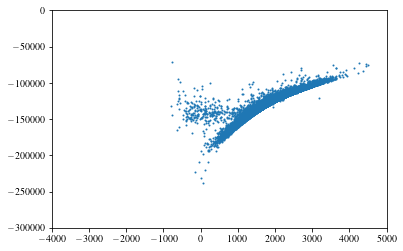

In [20]:
plt.scatter(data['actions'][:,1][mask&lowa_disc_mask]*-1,data['E'][mask&lowa_disc_mask],s=1)
plt.xlim(-4000,5000)
plt.ylim(-3e5,0)

In [21]:
cnfe = np.log10(10**(data['C_FE']+data['FE_H']+8.39) + 10**(data['N_FE']+data['FE_H']+7.78)) - np.log10(10.**8.39 + 10.**7.78) - data['FE_H']


In [26]:
lowa = mask&lowa_disc_mask
higha = mask&higha_disc_mask
higha_strict = mask&higha_disc_mask_strict
inta = mask&inta_disc_mask
oa = mask&other_mask
print(len(data[lowa]),len(data[higha]))

121413 49362


# all stars

In [54]:
import cmasher as cm
from scipy import stats

In [73]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=151):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True, rasterized=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [-0.1,-0.2,-0.1,-0.15,-0.2,-1]
        vmaxs = [0.4,0.4,0.1,0.15,0.2,0.4]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)

                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]

                binx = np.linspace(np.min(jy2/jphi_sun),np.max(jy2/jphi_sun),nbins)
                biny = np.linspace(np.min(jz2/jphi_sun),np.max(jz2/jphi_sun),nbins)
                hist = stats.binned_statistic_2d(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun, xfe2[mask_loop], statistic='mean', bins=[binx,biny])
                plot_x, plot_y = np.meshgrid(binx,biny) 
                color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap=cm.pride,vmin=vmins[indx],vmax=vmaxs[indx])         
                
#                 color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap=cm.pride,vmin=vmins[indx],vmax=vmaxs[indx])
            
                ax.set_xlim(0,15)
                ax.set_ylim(0,8)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(8,7,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
    fig.savefig('../plots/all_Rg_zmax_bins-allabun.pdf',dpi=150)



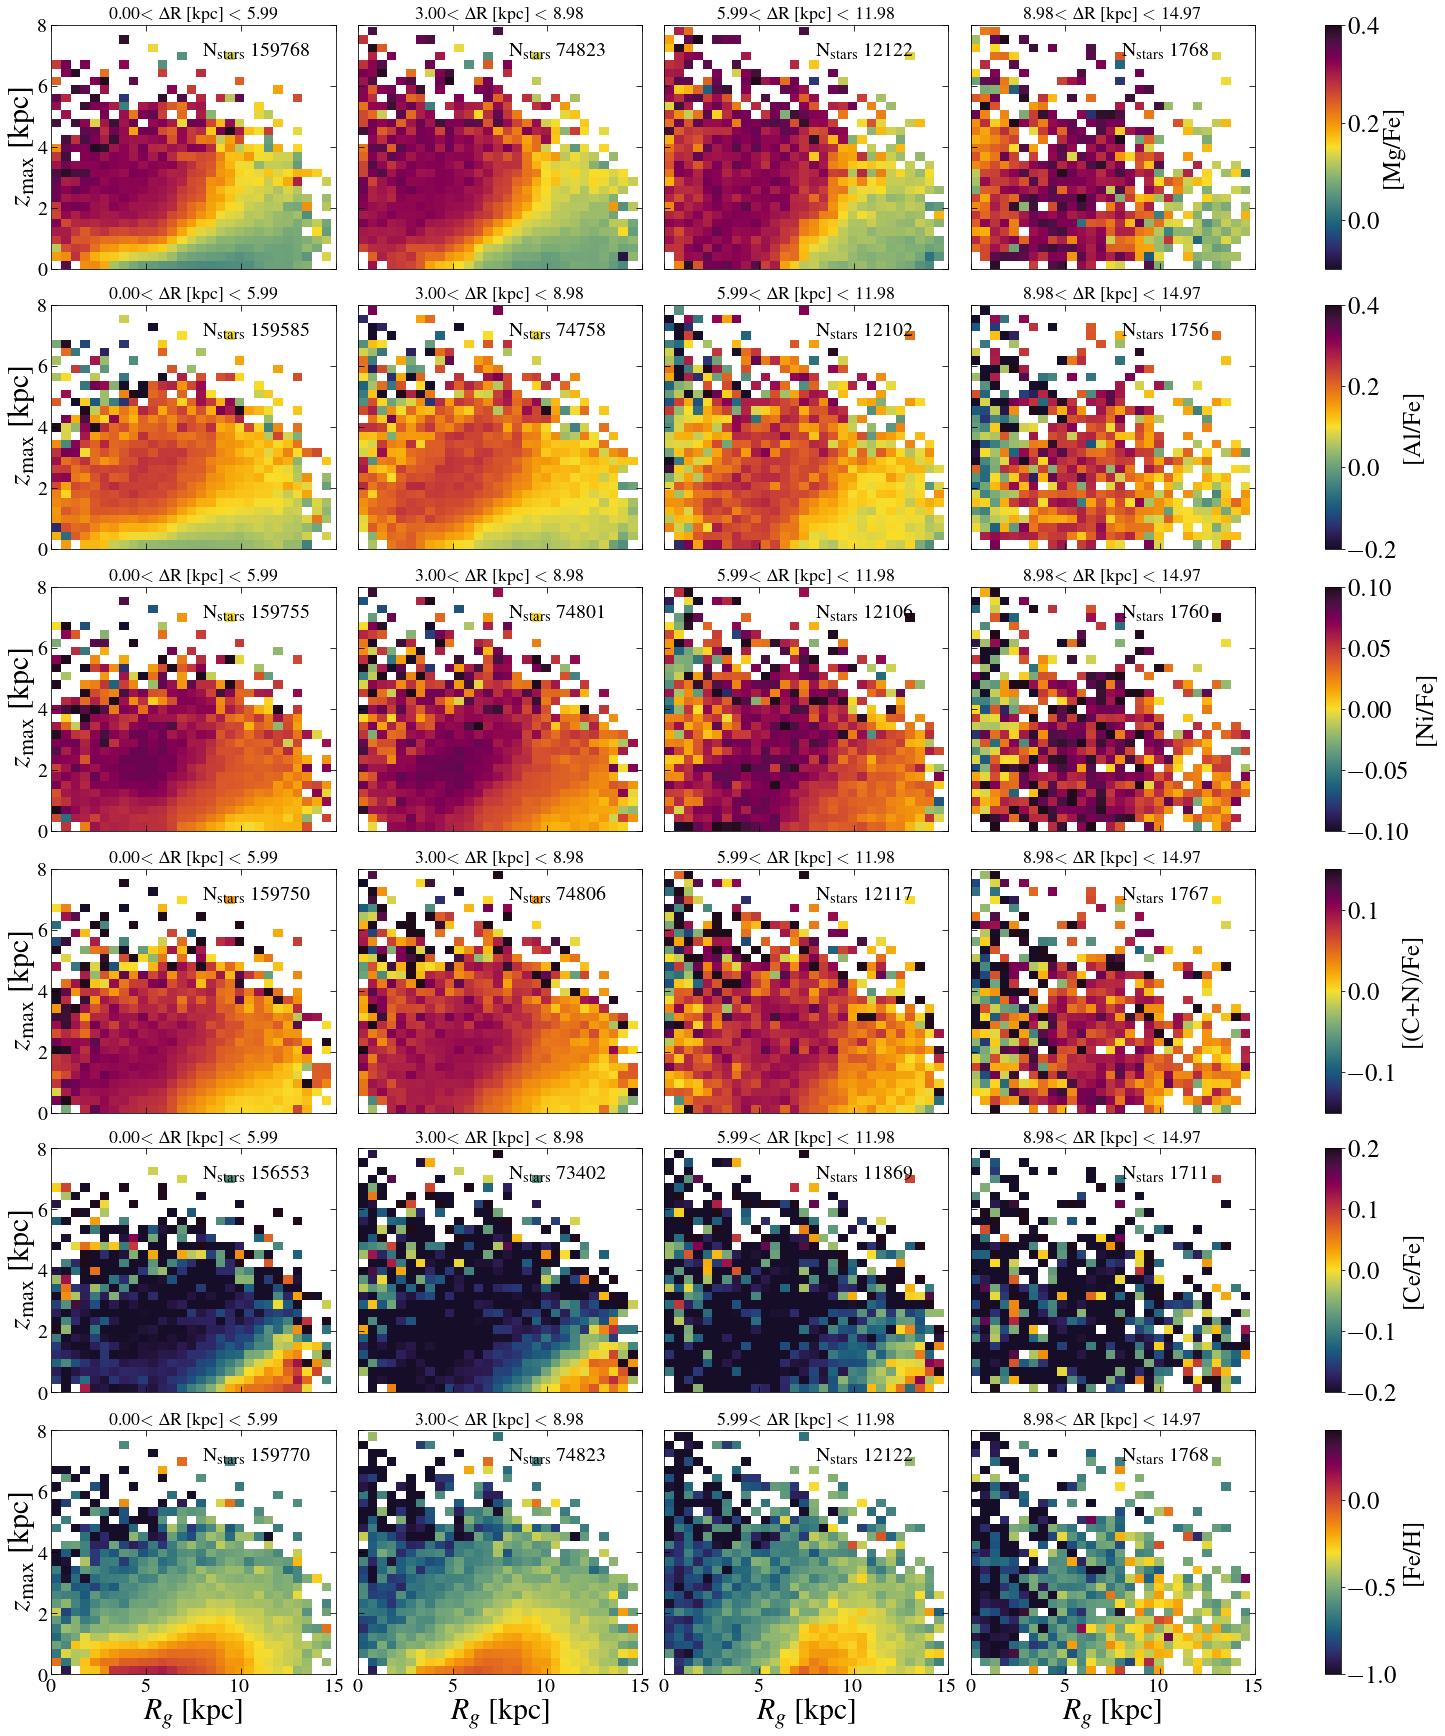

In [74]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):


xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<15)&(zmax<8)&(zmax>0)&(Rdelta<15)&(Rdelta>0)

plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,mask&omask,nbins=30,n=6)


In [ ]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=20):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['$\sigma_{\mathrm{[Mg/Fe]}}$','$\sigma_{\mathrm{[Al/Fe]}}$','$\sigma_{\mathrm{[Ni/Fe]}}$',\
                      '$\sigma_{\mathrm{[(C+N)/Fe]}}$','$\sigma_{\mathrm{[Ce/Fe]}}$','$\sigma_{\mathrm{[Fe/H]}}$']
        #vmins = [0.,-0.05,-0.05,-0.05,-0.2,-0.6]
        #vmaxs = [0.2,0.15,0.05,0.05,0.2,0.2]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)
                
                from matplotlib.colors import LogNorm
                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]
                
                
                # now create a grid and compute the statistic you want within a given cell
                binx = np.linspace(np.min(jy2),np.max(jy2),nbins)
                biny = np.linspace(np.min(jz2),np.max(jz2),nbins)    
                hist = stats.binned_statistic_2d(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun, xfe2[mask_loop], statistic='std', bins=[binx,biny])
                plot_x, plot_y = np.meshgrid(binx,biny)    
                color = ax.pcolormesh(plot_x, plot_y, hist[0].T, cmap="RdYlBu_r",norm=LogNorm())
                ax.set_aspect('equal')

                # color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap='RdYlBu_r',vmin=vmins[indx],vmax=vmaxs[indx])
                        
                ax.set_xlim(0,20)
                ax.set_ylim(0,15)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(10,12,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
    fig.savefig('../plots/lowa_Rg_zmax_scatter',dpi=150,format='png', rasterized=True)




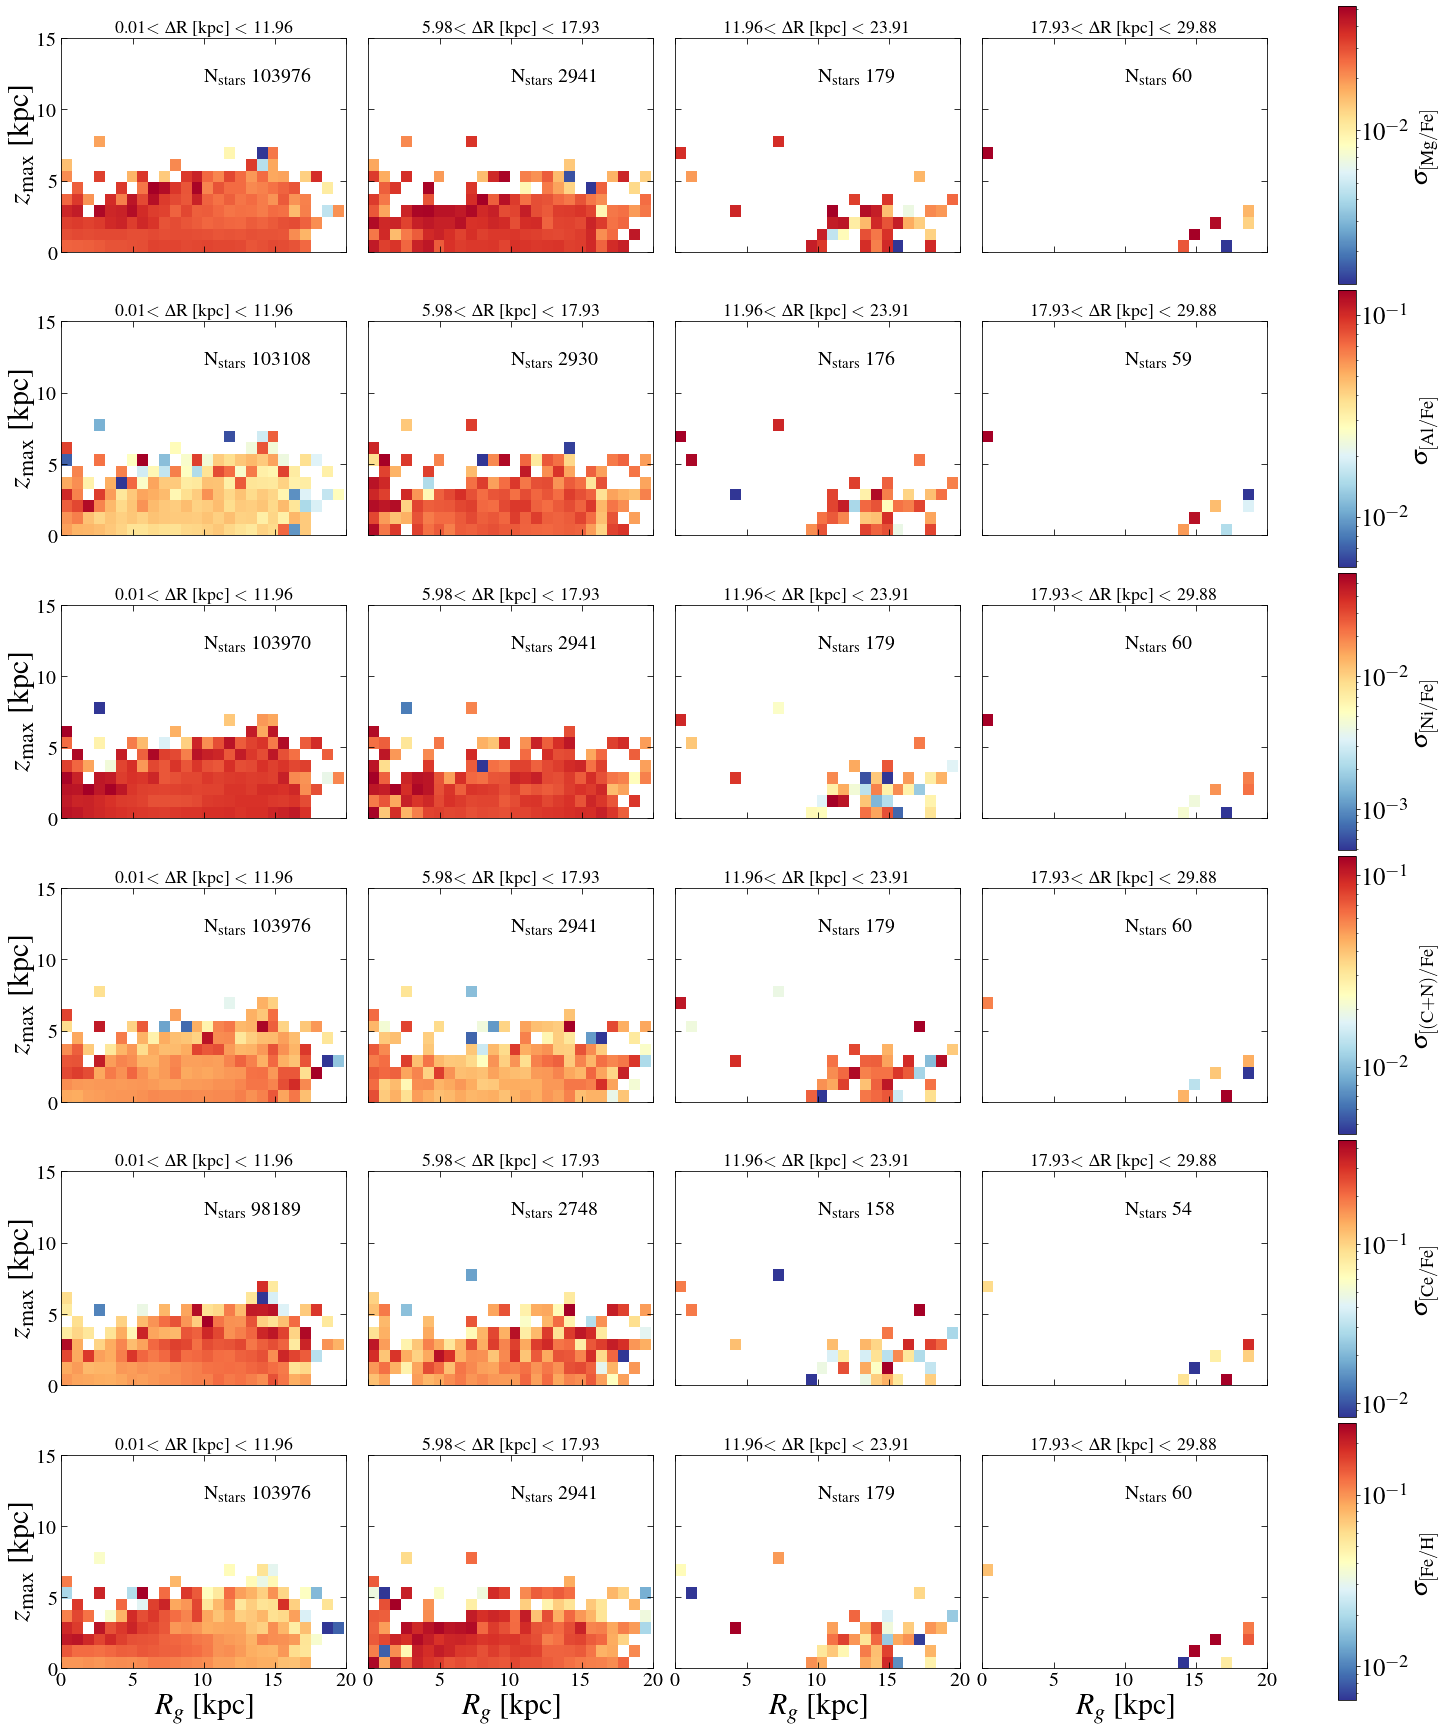

In [300]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):
from scipy import stats

xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<50)&(zmax<30)&(zmax>0)&(Rdelta<30)&(Rdelta>0)

lowa_omask = lowa&omask
plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,lowa_omask,nbins=30,n=6)


# And now do it for the high-$\alpha$ disc including the intermediate population

In [30]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=20):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [0.2,0.15,0.0,-0.05,-0.2,-0.8]
        vmaxs = [0.4,0.35,0.1,0.2,0.,-0.1]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)

                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]

                color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap='RdYlBu_r',vmin=vmins[indx],vmax=vmaxs[indx])
            
                
                ax.set_xlim(0,20)
                ax.set_ylim(0,8)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(10,12,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     fig.savefig('../plots/higha_Rg_zmax',dpi=150,format='png', rasterized=True)




Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x10b58be50>
Traceback (most recent call last):
  File "/Users/dhortadarrington/opt/anaconda3/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


TypeError: print_png() got an unexpected keyword argument 'rasterized'

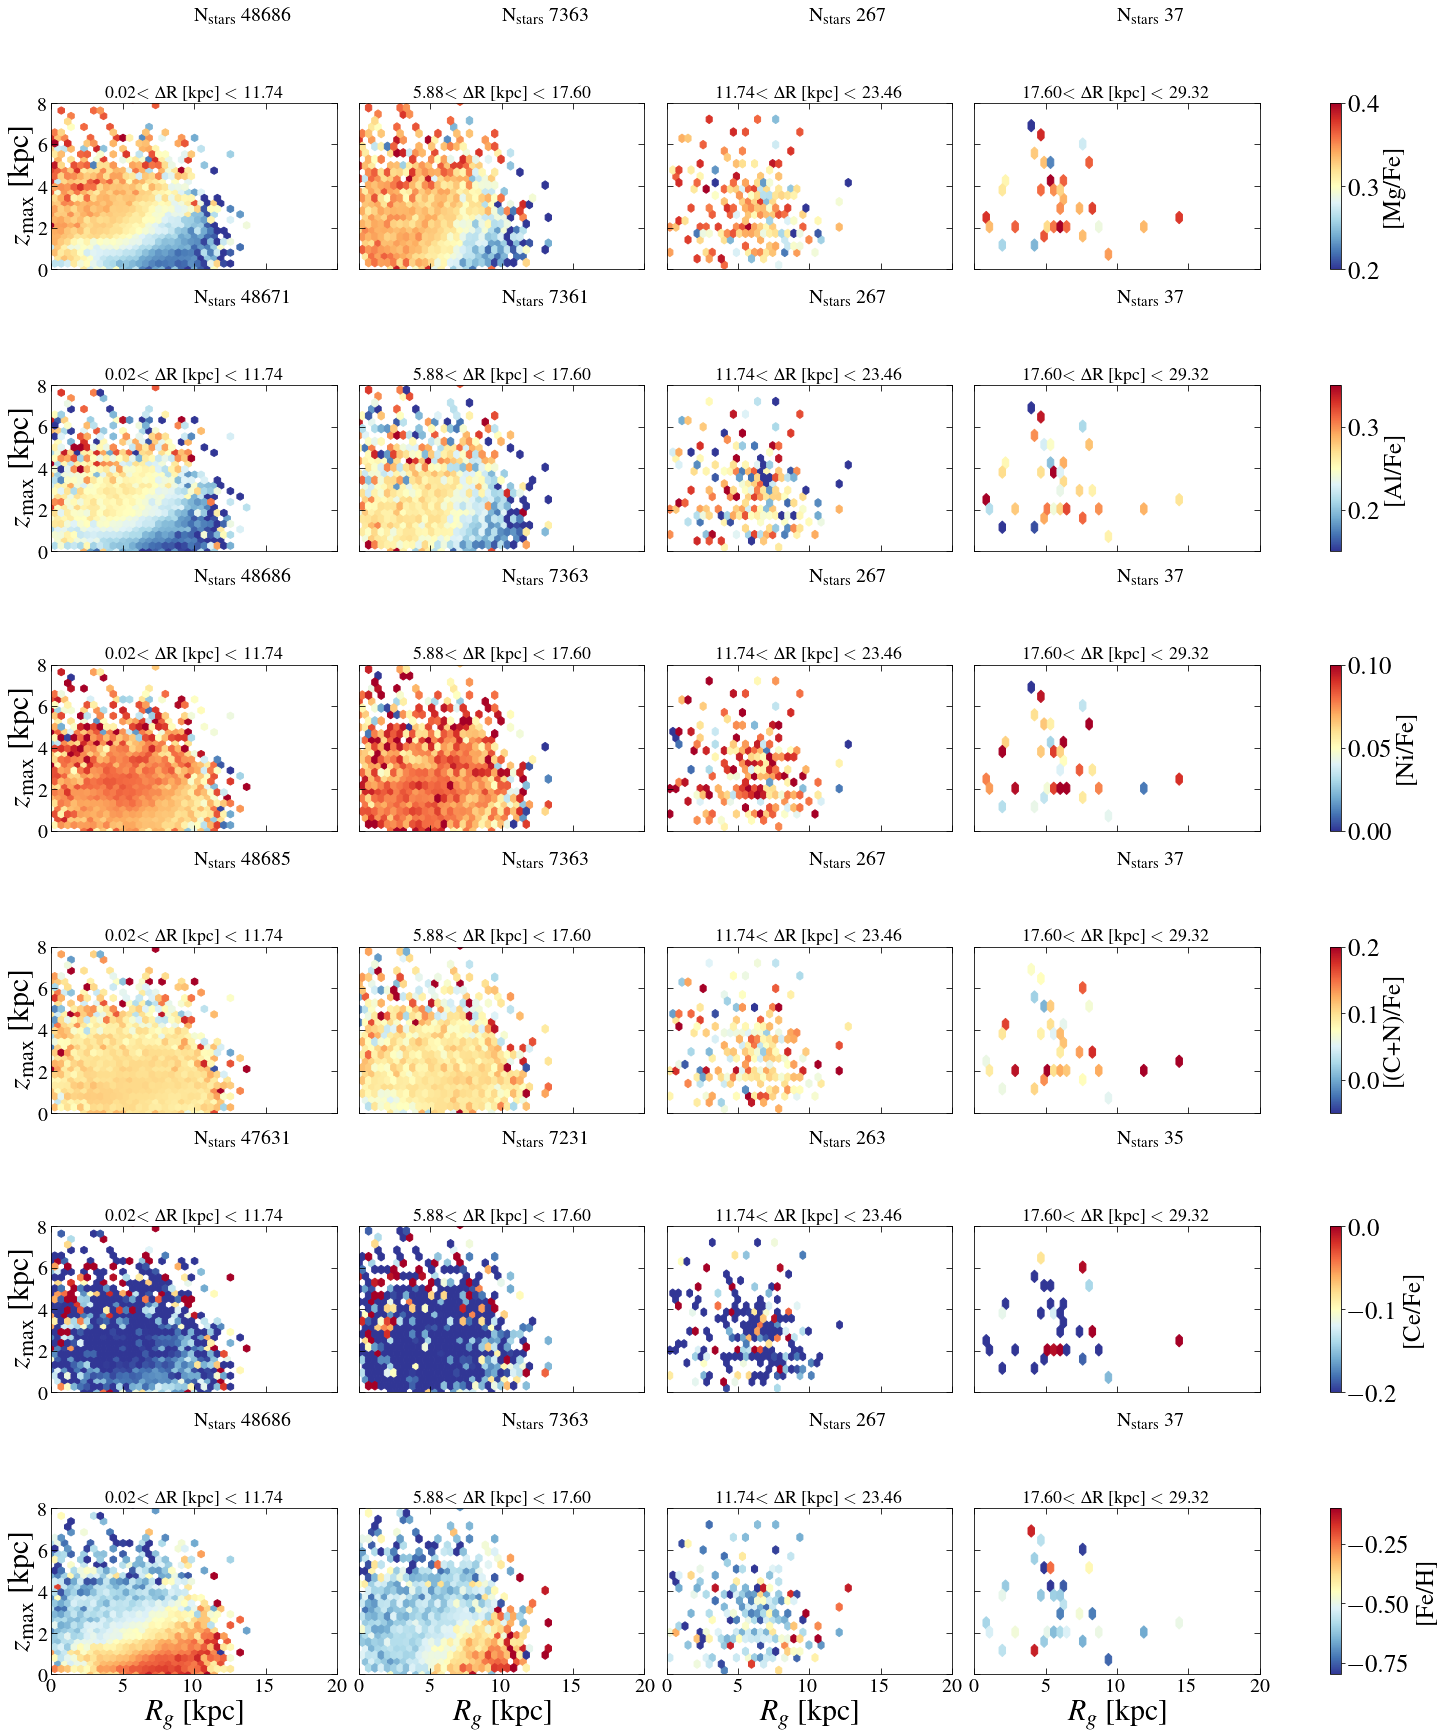

In [ ]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):


xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<50)&(zmax<30)&(zmax>0)&(Rdelta<30)&(Rdelta>0)

higha_omask = higha&omask
plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,higha_omask,nbins=30,n=6)


# Now the strict high-$\alpha$ disc sample

In [259]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=20):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [0.2,0.15,0.0,-0.05,-0.2,-0.8]
        vmaxs = [0.4,0.35,0.1,0.2,0.,-0.1]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)

                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]

                color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap='RdYlBu_r',vmin=vmins[indx],vmax=vmaxs[indx])
            
                
                ax.set_xlim(0,12)
                ax.set_ylim(0,7.5)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(6.5,6,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
    fig.savefig('../plots/higha_strict_Rg_zmax',dpi=150,format='png', rasterized=True)




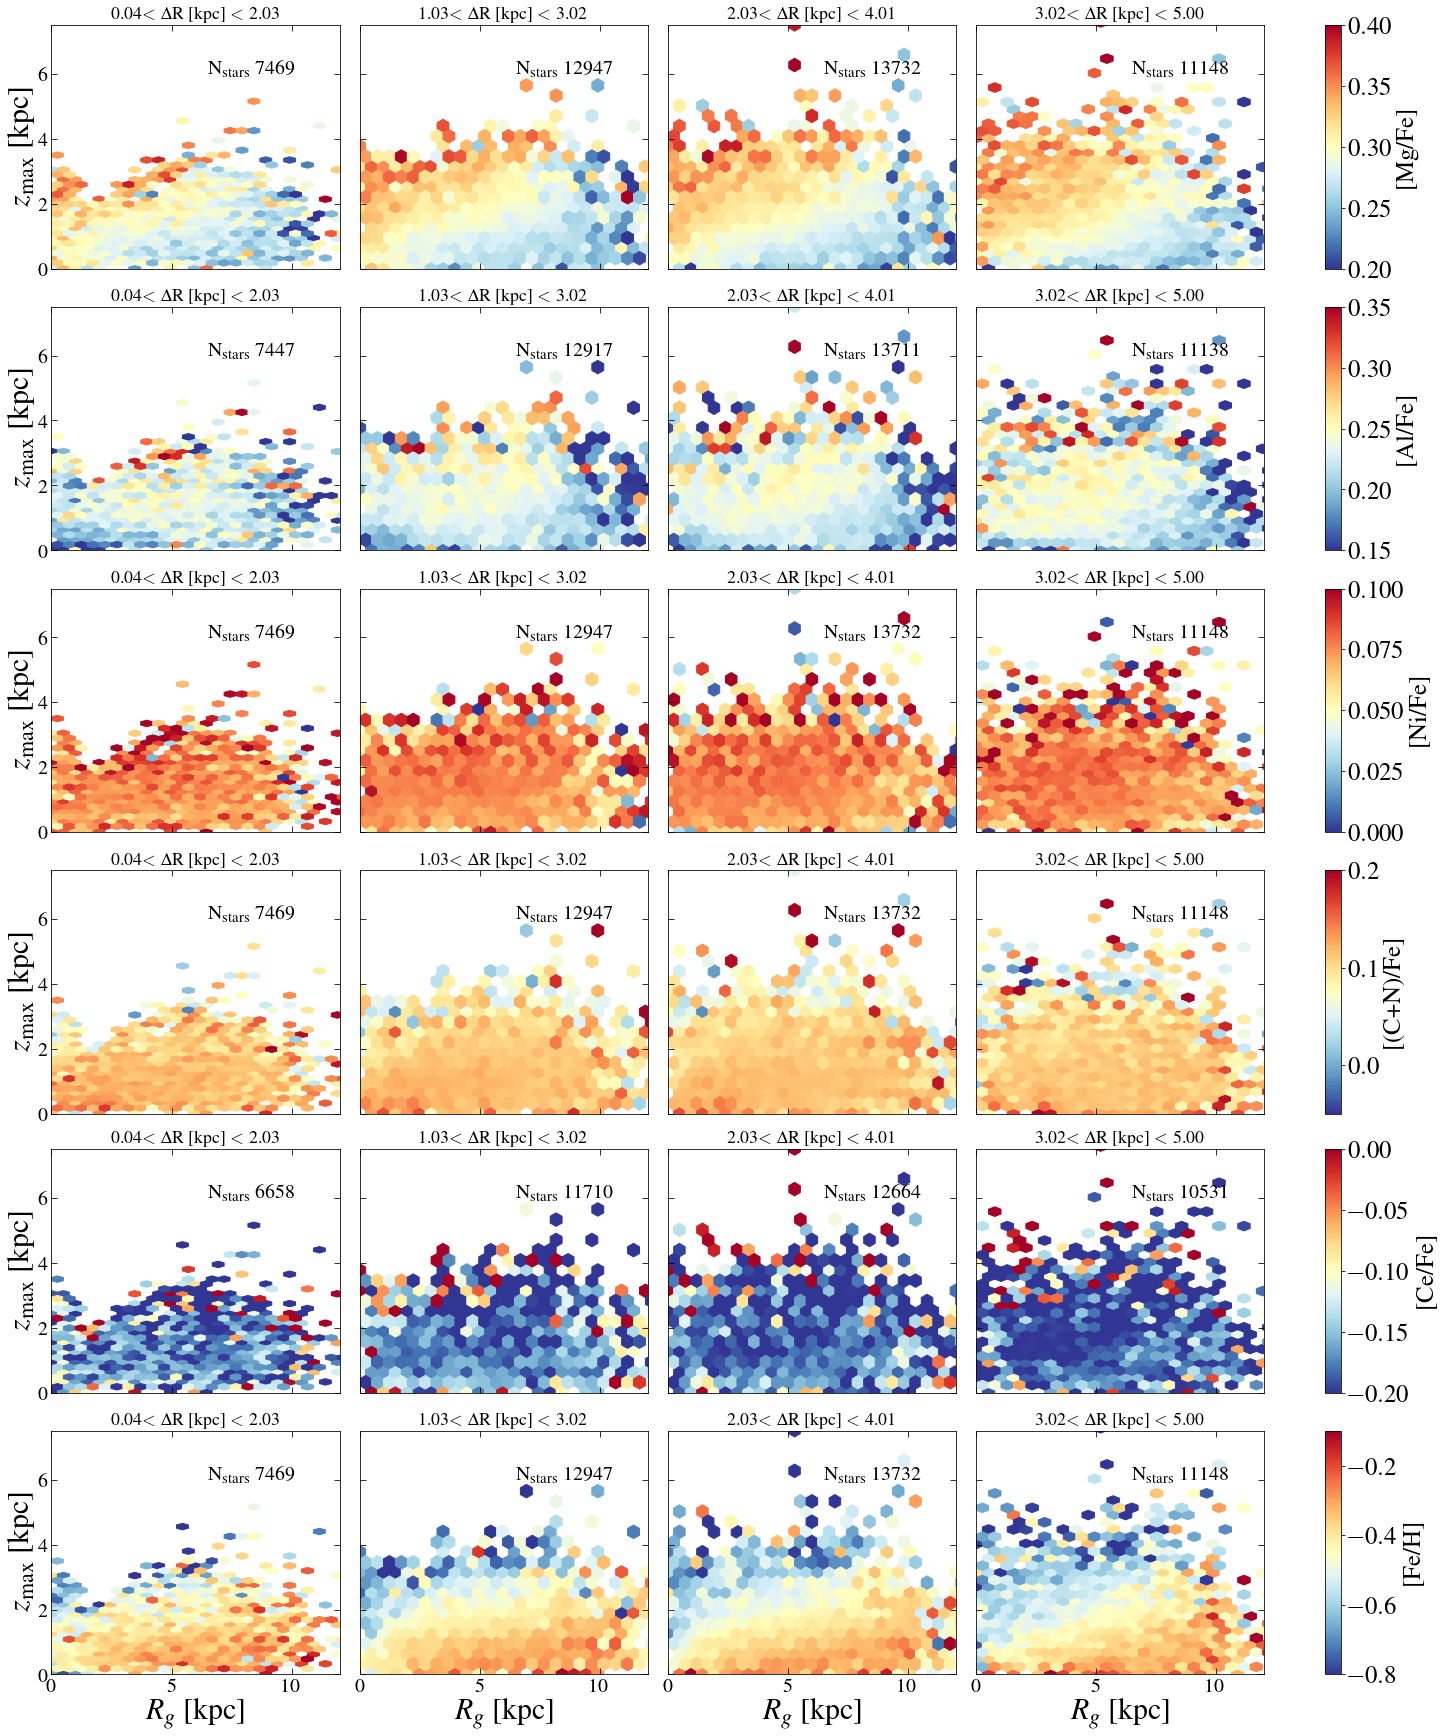

In [260]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):


xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<50)&(zmax<30)&(zmax>0)&(Rdelta<5)&(Rdelta>0)

higha_omask_strict = higha_strict&omask
plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,higha_omask_strict,nbins=30,n=6)


# Now the intermediate alpha stars

In [249]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=20):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [0.,-0.05,-0.05,-0.05,-0.2,-0.6]
        vmaxs = [0.2,0.15,0.05,0.05,0.2,0.2]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)

                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]

                color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap='RdYlBu_r',vmin=vmins[indx],vmax=vmaxs[indx])
            
                
                ax.set_xlim(0,20)
                ax.set_ylim(0,15)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(10,12,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
    fig.savefig('../plots/inta_Rg_zmax',dpi=150,format='png', rasterized=True)




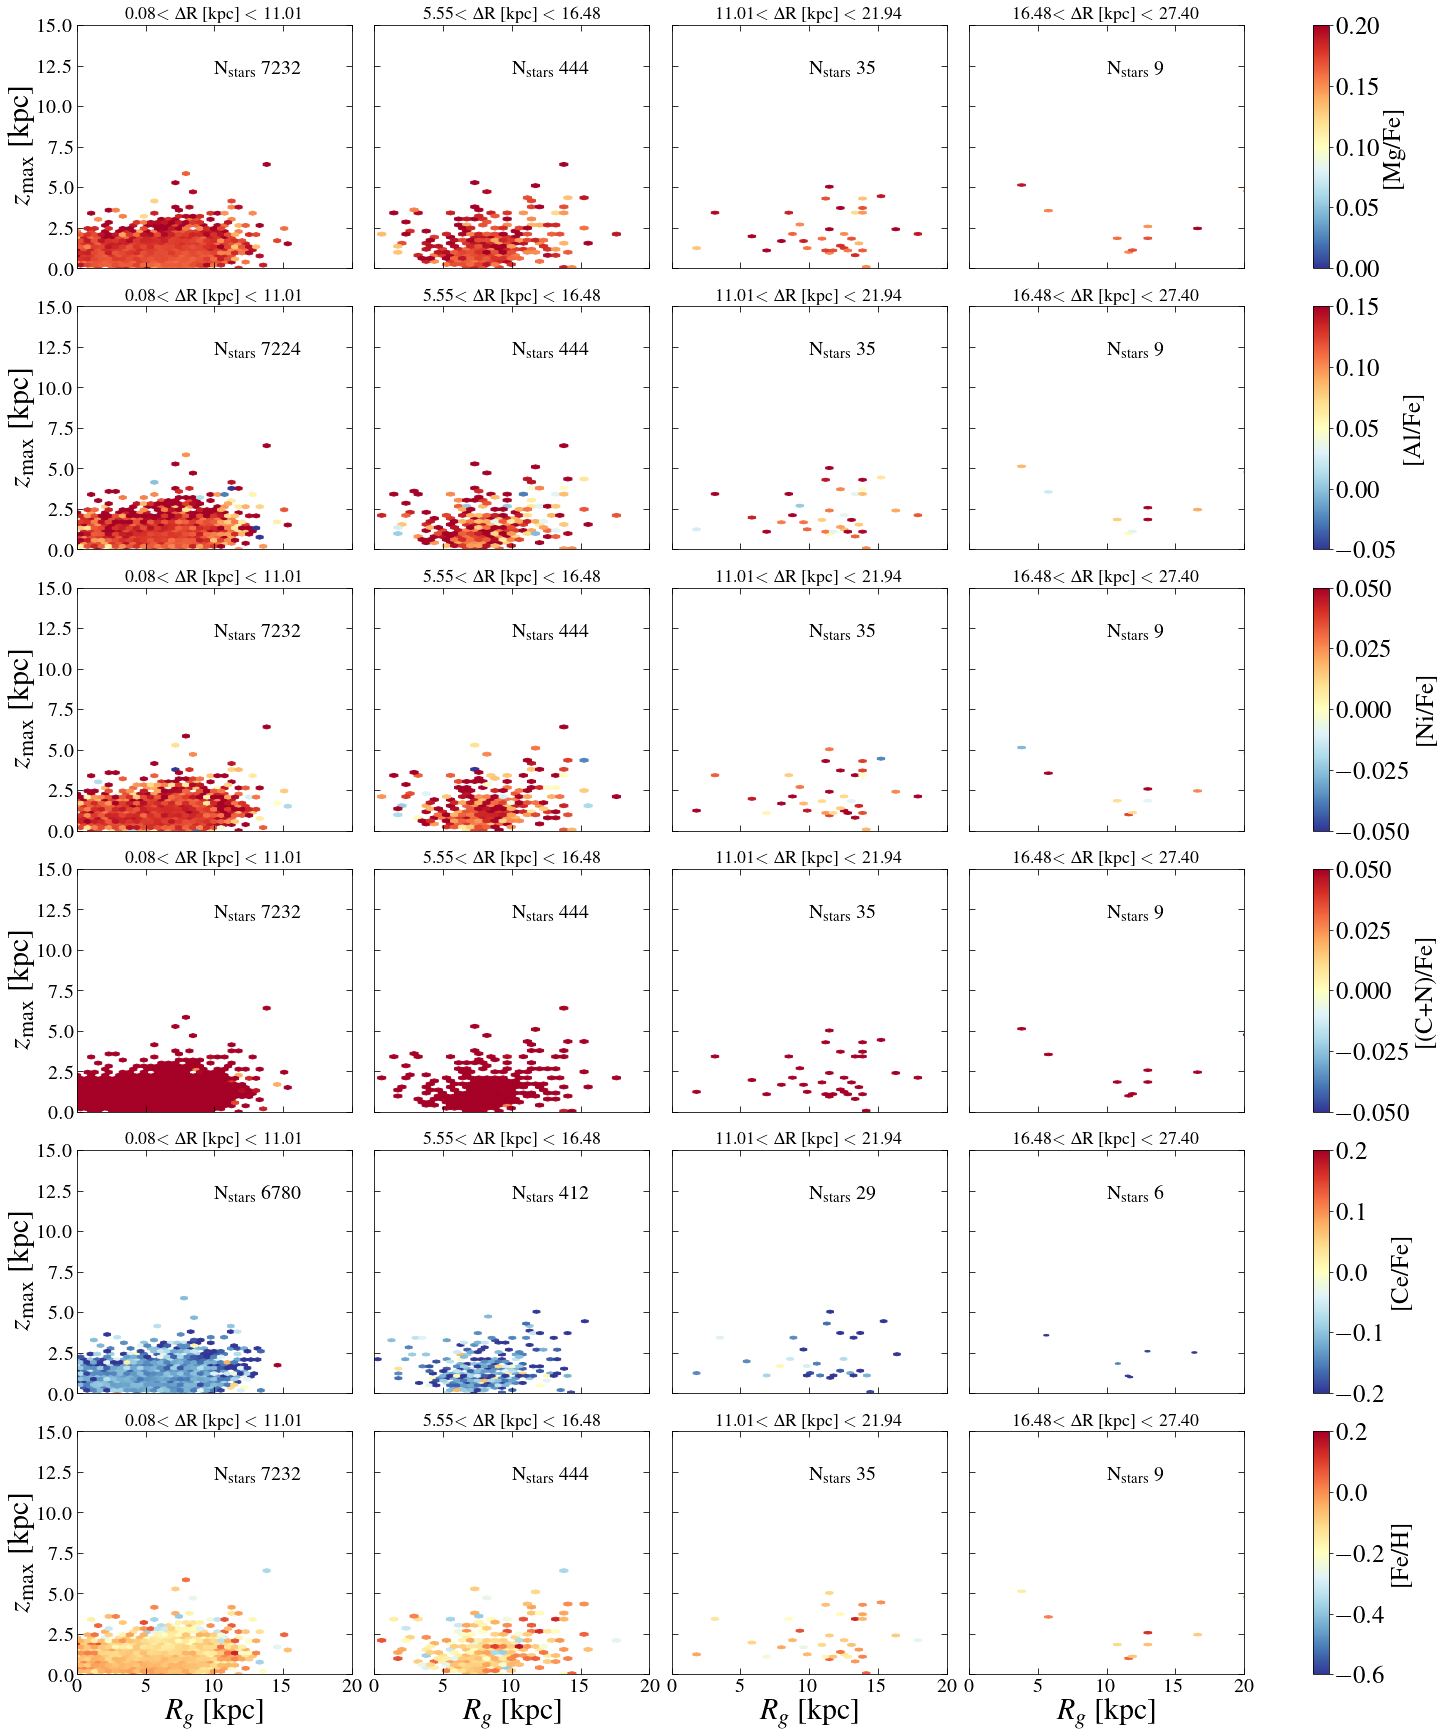

In [250]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):


xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<50)&(zmax<30)&(zmax>0)&(Rdelta<30)&(Rdelta>0)

inta_omask = inta&omask
plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,inta_omask,nbins=30,n=6)


# And now the other stuff (halo likely)

In [252]:
def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=10,nbins=20):

    fig, all_axes = plt.subplots(6, 4, constrained_layout=True, figsize=(20, 24), sharex=True, sharey=True)
    
    # loop over the abundances
    for indx, i in enumerate(xfe):
        axis = all_axes[indx]
        
        xfe_labels = ['[Mg/Fe]','[Al/Fe]','[Ni/Fe]','[(C+N)/Fe]','[Ce/Fe]','[Fe/H]']
        vmins = [-0.4,0.15,0.0,-0.05,-0.2,-2.]
        vmaxs = [0.6,0.35,0.1,0.2,0.,-0.8]

        
        xfe2 = i[disc_mask]
        jx2 = jx[disc_mask]
        jy2 = jy[disc_mask]
        jz2 = jz[disc_mask]
        # here we are in the space of [X/Fe] for all stars in our sample. We will now split the samples in n 
        # equal parts in a dimension of Jx (i.e., actions) and then plot chemical gradient of those stars in the other
        # orthogonal pair of actions (i.e., Jy, Jz)
        
        # we will split the range of dimension j (which here is jx) into n equal overlapping sections,
        # for now we will use n=9 to get 8 equal sections
        xs = np.around(np.linspace(np.min(jx2),np.max(jx2),n),decimals=2)

        # create the plot
        #fig = plt.figure(constrained_layout=True,figsize=(25,20))
        #gs = grid.GridSpec(4,5)
        #p = 0

        for indx2, k in enumerate(xs[:-1]):
            # create a mask for every loop
            if k<xs[-2]:
                mask_loop = (jx2>k)&(jx2<xs[indx2+2])&(xfe2>-10)

                # make the plot
                # ax = fig.add_subplot(gs[p])
                ax = axis[indx2]

                color = ax.hexbin(jy2[mask_loop]/jphi_sun,jz2[mask_loop]/jphi_sun,C=xfe2[mask_loop],gridsize=nbins,cmap='RdYlBu_r',vmin=vmins[indx],vmax=vmaxs[indx])
            
                
                ax.set_xlim(0,20)
                ax.set_ylim(0,15)
                ax.tick_params(direction='in',axis='both',length=6,right=True,top=True,labelsize=20)
                ax.text(10,12,r'N$_{\mathrm{stars}}$ '+str(len(jy2[mask_loop])),fontsize=20)
                #p+=1
                #axis = fig.axes
            else:
                pass
        #cbar_ax = fig.add_axes([0.4, 0.92, 0.06,0.006])
        #cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
        cbar = fig.colorbar(color, ax = axis, aspect=15)
        # cbar.set_label(label=r'L$_{z}$ [kpc kms$^{-1}$]',fontsize=20)
        cbar.set_label(label=xfe_labels[indx],fontsize=25)
        cbar.ax.tick_params(labelsize=25)

        axis[0].set_title(r'' +str('%5.2f' %xs[0])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[2]),fontsize=18)
        axis[1].set_title(r'' +str('%5.2f' %xs[1])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[3]),fontsize=18)
        axis[2].set_title(r'' +str('%5.2f' %xs[2])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[4]),fontsize=18)
        axis[3].set_title(r'' +str('%5.2f' %xs[3])+ r'$<$ $\Delta$R [kpc] $<$ '+str('%5.2f' %xs[5]),fontsize=18)

    for ax in all_axes[-1]:
        ax.set_xlabel('$R_{g}$ [kpc]',fontsize=30)
    for ax in all_axes[:, 0]:
        ax.set_ylabel('$z_{\mathrm{max}}$ [kpc]',fontsize=30)
#     axis[0].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[1].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[2].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)        
#     axis[3].set_ylabel('J$_{\phi}$/J$_{\phi,\odot}$',fontsize=20)
#     axis[3].set_xlabel('J$_{R}$/J$_{\phi,\odot}$',fontsize=20)
    fig.savefig('../plots/other_Rg_zmax',dpi=150,format='png', rasterized=True)




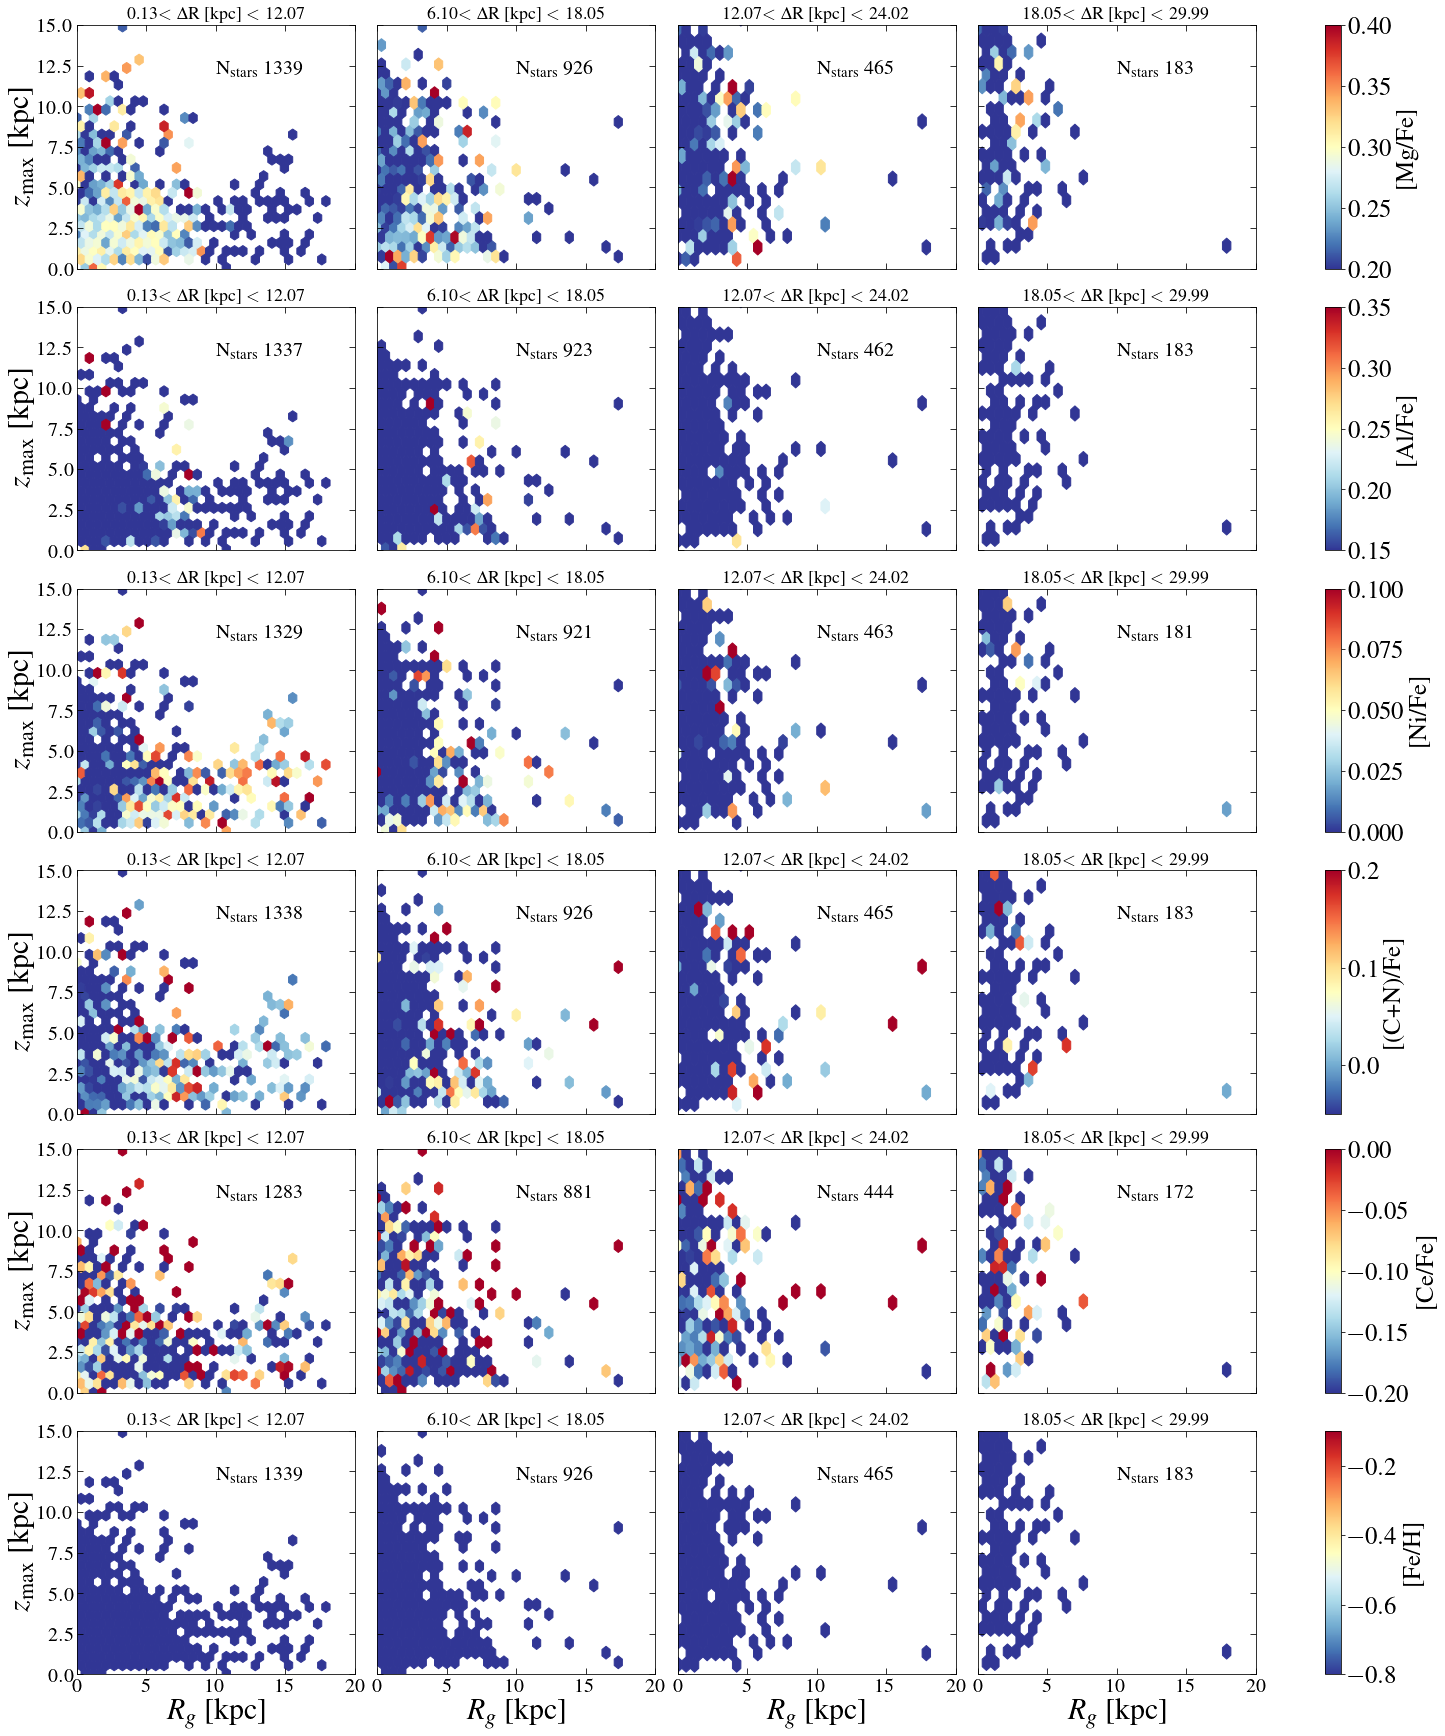

In [253]:
# def plot_xfe_actions(xfe,jx,jy,jz,jphi_sun,disc_mask,n=9,nbins=50, jjx=True, jjy=False,jjz=False):


xfe=np.dstack([data['MG_FE'],data['AL_FE'],data['NI_FE'],cnfe,data['CE_FE'],data['FE_H']])[0].T

omask = (Rg>0)&(Rg<50)&(zmax<30)&(zmax>0)&(Rdelta<30)&(Rdelta>0)

othera_omask = oa&omask
plot_xfe_actions(xfe,Rdelta,Rg,zmax,1.,othera_omask,nbins=30,n=6)
